# Kernel Multivariate Analysis Assignment


*Ainara Apezteguia García, NIA: 100418610*  

*Frederik Chettouh, NIA: 100419069*


In this assignment we employ different Multivariate Kernel Methods. 
All functions except minor helpers and plotters can be found in the klda, utils and kcca files.

## Setup 
We first load all packages, set the seed for reproducibility and load and prep the data. We will use a dictionary to keep track of and reuse intermediate data.

In [1]:
# LOADING ALL NECCESSARY PACKAGES


# ML PACKAGES
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import PCA

# CUSTOM PACKAGES
from klda import centred_kernel, kgda, predict_kgda
from utils import get_train_test, combine_kernel, sorted_spectrum,get_train_test_idx
from kcca import normalize, _core ,PGSO, reg_cca ,KCCA


# UTIL PACKAGES
import numpy as np
import matplotlib.pyplot as plt
seed = 0

In [2]:
import scipy.io
mat = scipy.io.loadmat('./data/datos.mat')
terms = mat['Terms']
termDoc = mat['termDoc']
y = mat['Target']
x = mat['x']
list_of_terms = [cc[0] for cc in terms[0]]

targets = y-1
   
pics_captions = [(x[0][cc][0], x[0][cc][1][0]) for cc in range(1200)]
termDoc = termDoc.T

In [3]:
 idx_train, idx_test = get_train_test_idx()

In [4]:
# WE SAVE THE DATA IN A DICTIONARY TO BE ABLE TO ITERATE AND ADD VARIATIONS OF IT
color = np.loadtxt('data/color_features.csv')
feature = np.loadtxt('data/texture_features.csv')
bow = np.loadtxt('data/bow_features.csv')
features = {"color": {'X':color},
            "texture": {'X':feature},
            "bow": {'X':bow}
           }
kernel_types = ['rbf', 'poly', 'linear']

## Extend the KLDA analysis of likeliness of each feature

- Explore for each of the three features: color, texture and bag-of-words, which is the kernel that achieves a better generalization using KLDA **(3 points)**

In [5]:
for key in features.keys():
    
    np.random.seed()
    
#   GETTING TRAIN AND TEST PARTITIONS  
    features[key]['X_train'], features[key]['X_test'] = features[key]['X'][idx_train],features[key]['X'][idx_test]
    features[key]['y_train'], features[key]['y_test'] = targets[0][idx_train], targets[0][idx_test]
    
    scaler = StandardScaler()

#   SCALING THE DATA  
    features[key]['X_train_scaled'] = scaler.fit_transform(features[key]['X_train'])
    features[key]['X_test_scaled'] = scaler.transform(features[key]['X_test'])

#   COMPUTING THE KLDA FOR EACH KERNEL TYPE
    for kernel_type in kernel_types:
        kernel = centred_kernel(kernel_type)
        features[key][f'X_train_{kernel_type}'] = kernel.fit_transform(features[key]['X_train_scaled'])
        features[key][f'X_test_{kernel_type}'] = kernel.transform(features[key]['X_test_scaled'])
        
        A, Q = kgda(
            features[key][f'X_train_{kernel_type}'],
            features[key]['y_train'])
        
        pred_train, U_train = predict_kgda(
            features[key][f'X_train_{kernel_type}'],A, Q)
        
        pred_test, U_test = predict_kgda(
            features[key][f'X_test_{kernel_type}'], A, Q)
        
#       EVALUATNING THE MODEL
        features[key][f'{kernel_type}_train_error'] = \
        100*np.mean(features[key]['y_train'] != pred_train)
        features[key][f'{kernel_type}_test_error'] = \
        100*np.mean(features[key]['y_test'] != pred_test)

    
    

In [6]:
errors = {}
for key in features.keys():
    for name in features[key].keys():
        if 'error' in name:
            errors[f'{key}_{name}'] = features[key][name]

In [7]:
reversed_errors = [(error,feature_kernel_combination) for feature_kernel_combination, error
                in list(errors.items()) if "test" in  feature_kernel_combination]
sorted_errors = sorted(reversed_errors)

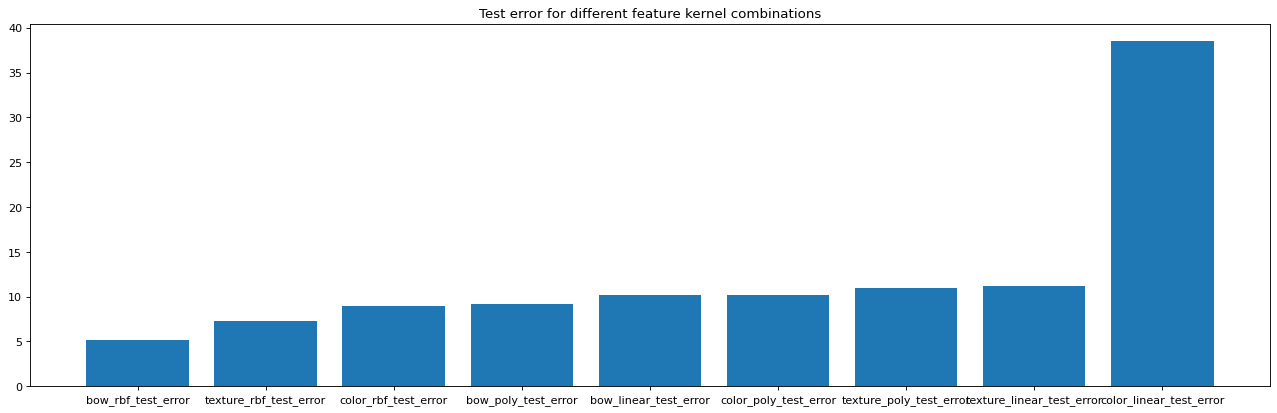

In [8]:
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar([tup[1] for tup in sorted_errors],
        [tup[0] for tup in sorted_errors])
plt.title('Test error for different feature kernel combinations')
plt.show()
plt.close(0)

As we can see different Features and kernels behave differently. Bag of words RBF Kernel works best but also for the other two featues the RBF Kernel works best.

- **Extra** The two image features could be combined in a composite kernel (like those visited in the SVM assignment). Consider also KLDA with a kernel that is the sum of kernels on the two image features **(2 extra points)**

In [9]:
# ESSENTIALLY WE DO THE SAME AS BEFORE BUT FOR ALL POSSIBLE KERNEL COMBINATIONS (9)
# WE COMBINE THE KERNELS 
# ALPHA OR THE WEIGHT OF EACH KERNEL IS SET TO A DEFAULT VALUE of 0.5

features['color_texture'] ={}
for i in range(len(kernel_types)):
    for j in range(len(kernel_types)):
        
        np.random.seed(0)
#       WE ARE REAUSING THE DATA FROM THE PREVIOUS EXPERIMENTS FROM THE FEATURES DICT  
        features['color_texture']['y_train'] ,features['color_texture']['y_test'] = targets[0][idx_train],targets[0][idx_test]        
        temp_X_train_1 = features['color']['X'][idx_train]
        temp_X_test_1 = features['color']['X'][idx_test]
        
        temp_X_train_2 = features['texture']['X'][idx_train]
        temp_X_test_2 = features['texture']['X'][idx_test]
        
        kernel1 = centred_kernel(kernel_types[i])
        kernel_train_1 = kernel1.fit_transform(temp_X_train_1)
        kernel_test_1 = kernel1.transform(temp_X_test_1)
        
        kernel2 = centred_kernel(kernel_types[j])
        kernel_train_2 = kernel2.fit_transform(temp_X_train_2)
        kernel_test_2= kernel2.transform(temp_X_test_2)
        
#       COMBINING THE TWO KERNELS          
        features['color_texture'][f'X_train_{kernel_types[i]}_{kernel_types[j]}']=\
        combine_kernel(
            kernel_train_1,
            kernel_train_2,
            alpha=0.5)
        
        features['color_texture'][f'X_test_{kernel_types[i]}_{kernel_types[j]}']=\
        combine_kernel(
            kernel_test_1,
            kernel_test_2,
            alpha=0.5)
        
#       # CALCULATING THE KLDA
        A, Q = kgda(
            features['color_texture'][f'X_train_{kernel_types[i]}_{kernel_types[j]}'],
            features['color_texture']['y_train'])
        
        
        pred_train, U_train = predict_kgda(
            features['color_texture'][f'X_train_{kernel_types[i]}_{kernel_types[j]}']
            ,A, Q)
        
        pred_test, U_test = predict_kgda(
            features['color_texture'][f'X_test_{kernel_types[i]}_{kernel_types[j]}'],
            A, Q)
        
        features['color_texture'][f'{kernel_types[i]}_{kernel_types[j]}_train_error'] = \
        100*np.mean(features['color_texture']['y_train'] != pred_train)
        features['color_texture'][f'{kernel_types[i]}_{kernel_types[j]}_test_error'] = \
        100*np.mean(features['color_texture']['y_test'] != pred_test)
 

In [10]:
results = []
for i in kernel_types:
    for j in kernel_types:
        results.append((features['color_texture'][f'{i}_{j}_test_error'],f'{i}_{j}'))
results = sorted(results)        

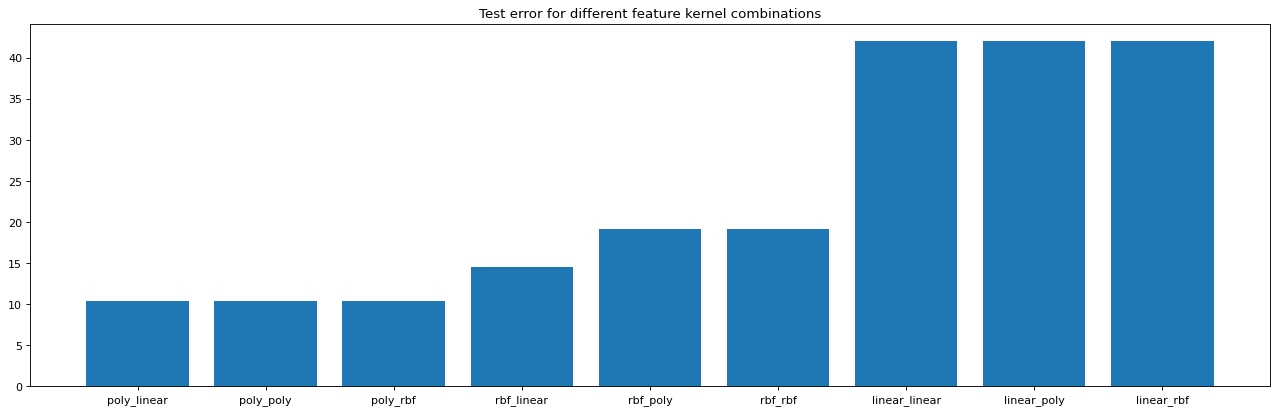

In [11]:
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar([tup[1] for tup in results],
        [tup[0] for tup in results])
plt.title('Test error for different feature kernel combinations')
plt.show()
plt.close(0)

## Extend the KCCA content based retrieval to other kernels
- Explore combinations of the two image features as first view for the KCCA **(3 points)**

In [12]:
# PREPPING THE TEXT FEATURE --> COLOR FEATURE IS ALREADY COMPUTED

K_train_1 = features['color']['X_train_rbf']
K_test_1  = features['color']['X_test_rbf']


mod_texto = np.linalg.norm(termDoc,2,axis=1)
textos_n = termDoc / np.tile(mod_texto.reshape(-1,1), (1,termDoc.shape[1]))
texto_train_n = textos_n[idx_train, :]
texto_test_n = textos_n[idx_test, :]


kernel_texto = centred_kernel(kernel='linear')
K_texto_train = kernel_texto.fit_transform(texto_train_n)
K_texto_test = kernel_texto.transform(texto_test_n)

K_train_2 = K_texto_train
K_test_2 = K_texto_test



## Baseline Model

In [13]:
kcca_results = {}
kcca_results['baseline'] = {
    'configuration': {
        'n_components':60,
        'n_components_used': 5,
        'images_to_retrive': 10,
        'K_train_1': features['color']['X_train_rbf'],
        'K_test_1': features['color']['X_test_rbf']
    }
}
kcca_results['y_test'] = targets[0][idx_test]
kcca_results['targets'] = targets

In [14]:
my_cca = KCCA(n_components = kcca_results['baseline']['configuration']['n_components'],
                 dim_first_view = 'half',
                 kernel1='precomputed', 
                 kernel2='precomputed',
                 center_kernels=True,
                tau=1e-2)

In [15]:
# WITH JUST THE COLOR FEATURE 
kcca_results['baseline']['accuracy'] = cca.run_experiment(
                      kcca_results['baseline']['configuration']['K_train_1'],
                      kcca_results['baseline']['configuration']['K_test_1'],
                      K_train_2,
                      K_test_2,
                      linear_kernel,
                      kcca_results['y_test'],
                      kcca_results['targets'],
                      idx_test
                     )

## Combining Features

There are several ways to combine the first view.

1. just texture vs. just color different kernels
3. kernel combinations
4. PCA 

In [35]:
def admin_experiment(list_of_keys, configurations,  K_train_2=K_train_2,
                     K_test_2=K_test_2,
                     linear_kernel=linear_kernel,
                     idx_test=idx_test):
    for key in list_of_keys:
        cca = KCCA(n_components = configurations[key]['configuration']['n_components'],
                 dim_first_view = 'half',
                 kernel1='precomputed', 
                 kernel2='precomputed',
                 center_kernels=True,
                tau=1e-2)
        kcca_results[key]['accuracy'] = cca.run_experiment(
                      configurations[key]['configuration']['K_train_1'],
                      configurations[key]['configuration']['K_test_1'],
                      K_train_2,
                      K_test_2,
                      linear_kernel,
                      configurations['y_test'],
                      configurations['targets'],
                      idx_test
                     )
    return configurations

### 1. just texture vs. just color different kernels


In [17]:
for feature in ['color', 'texture']:
    for kernel_type in kernel_types:
        
        configs = {
        'n_components':60,
        'n_components_used': 5,
        'images_to_retrive': 10,
        'K_train_1': features[feature][f'X_train_{kernel_type}'],
        'K_test_1': features[feature][f'X_test_{kernel_type}']
    }
        
        kcca_results[f'{feature}_{kernel_type}'] = {}
        kcca_results[f'{feature}_{kernel_type}']['configuration'] =configs

In [18]:
keys = []
for feature in ['color', 'texture']:
    for kernel_type in kernel_types:
        keys.append(f'{feature}_{kernel_type}')

In [19]:
kcca_results = admin_experiment(keys,kcca_results)

###  Kernel combinations

In [20]:
for i in range(len(kernel_types)):
    for j in range(len(kernel_types)):
            
        configs = {
        'n_components':60,
        'n_components_used': 5,
        'images_to_retrive': 10,
        'K_train_1': features['color_texture'][f'X_train_{kernel_types[i]}_{kernel_types[j]}'],
        'K_test_1': features['color_texture'][f'X_test_{kernel_types[i]}_{kernel_types[j]}']
    }
        
        kcca_results[f'color_texture_{kernel_types[i]}_{kernel_types[j]}'] = {}
        kcca_results[f'color_texture_{kernel_types[i]}_{kernel_types[j]}']['configuration'] = configs

In [21]:
combination_keys = []
for feature in ['color_texture']:
    for i in range(len(kernel_types)):
        for j in range(len(kernel_types)):
            combination_keys.append(f'{feature}_{kernel_types[i]}_{kernel_types[j]}')

In [22]:
kcca_results = admin_experiment(combination_keys,kcca_results)

### PCA

The elbow plot shoes that using 100 components should be enough so we will explore the range from 10 to 110 with a step size of 20

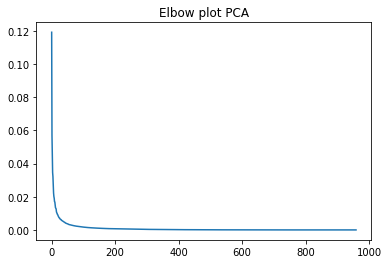

In [23]:
features['color_texture']['X'] = np.concatenate((features['color']['X'],features['texture']['X']),axis=1)
pca = PCA().fit(features['color_texture']['X'])
pca.explained_variance_ratio_
features['color_texture']['pca_all'] = pca.transform(features['color_texture']['X'])
plt.plot(np.arange(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)
plt.title('Elbow plot PCA')
plt.show()
plt.close()

In [24]:
for i in range(10,111,20):
    pca_train = features['color_texture']['pca_all'][:,:i][idx_train, :]
    pca_test =  features['color_texture']['pca_all'][:,:i][idx_test, :]

    pca_scaler = StandardScaler()
    pca_train_n = pca_scaler.fit_transform(pca_train)
    pca_test_n = pca_scaler.transform(pca_test)
    
    kernel_pca = centred_kernel(kernel='rbf')

    K_pca_train = kernel_pca.fit_transform(pca_train_n)
    K_pca_test = kernel_pca.transform(pca_test_n)

    features['color_texture'][f'X_train_pca_{i}'] = K_pca_train
    features['color_texture'][f'X_test_pca_{i}'] = K_pca_test

In [25]:
for i in range(10,111,20):
    configs = {
        'n_components':60,
        'n_components_used': 5,
        'images_to_retrive': 10,
        'K_train_1': features['color_texture'][f'X_train_pca_{i}'],
        'K_test_1': features['color_texture'][f'X_test_pca_{i}']
    }
        
    kcca_results[f'color_texture_pca_{i}'] = {}
    kcca_results[f'color_texture_pca_{i}']['configuration'] = configs

In [26]:
pca_keys = []
for feature in ['color_texture']:
    for i in range(10,111,20):
        pca_keys.append(f'{feature}_pca_{i}')

In [27]:
kcca_results = admin_experiment(pca_keys, kcca_results)

### Comparing results to get best configuration

In [29]:
results = {key:kcca_results[key].get('accuracy') if type(kcca_results[key])==dict else None for key in kcca_results.keys()}
sorted_results = sorted([(value,key) for key, value in results.items() if value], reverse=True)

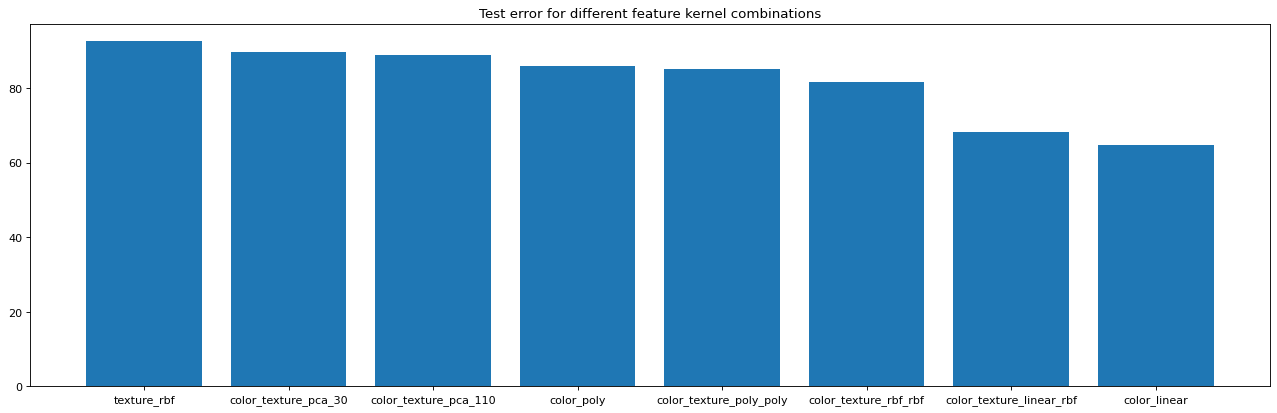

In [30]:
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar([tup[1] for tup in sorted_results[::3]],
        [tup[0] for tup in sorted_results[::3]])
plt.title('Test error for different feature kernel combinations')
plt.show()
plt.close(0)

In [39]:
best_config_key = sorted_results[0][1]
print(sorted_results[0])
base_line_accuracy = kcca_results['baseline'].get('accuracy')
print(f"Baseline model accuracy is {base_line_accuracy}")

(92.58333333333333, 'texture_rbf')
Baseline model accuracy is 88.2


Different feature combinations lead to an improvement of 4% in performance

## Performance as a function of Components and images retrieved

In [32]:
sensitivity_results = {}


In [33]:
K_train_1 = kcca_results[best_config_key]['configuration']['K_train_1']
K_test_1  = kcca_results[best_config_key]['configuration']['K_test_1']

In [40]:
# first showing performance as a function of compenents used
cca = KCCA(n_components = 60,
                 dim_first_view = 'half',
                 kernel1='precomputed', 
                 kernel2='precomputed',
                 center_kernels=True,
                tau=1e-2)

sensitivity_results['variable_components'] = {} 
for i in range(1,61,1):
    sensitivity_results['variable_components'][i] = cca.run_experiment(K_train_1,
                       K_test_1,
                       K_train_2,
                       K_test_2,
                       linear_kernel,
                       kcca_results['y_test'],
                       kcca_results['targets'],
                       idx_test,
                       nc_use=i
                     )
    

In [41]:
# first showing performance as a function of compenents used
sensitivity_results['variable_images_retrieved'] = {} 
for i in range(1,200,30):
    sensitivity_results['variable_images_retrieved'][i] = cca.run_experiment(K_train_1,
                       K_test_1,
                       K_train_2,
                       K_test_2,
                       linear_kernel,
                       kcca_results['y_test'],
                       kcca_results['targets'],
                       idx_test,
                       n_images=i
                     )
    

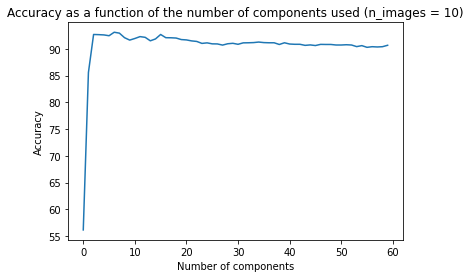

In [42]:
plt.plot(
    np.arange(len(sensitivity_results['variable_components'].keys())),
    [value for value in list(sensitivity_results['variable_components'].values())]
)
plt.title('Accuracy as a function of the number of components used (n_images = 10)')
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.show()
plt.close()

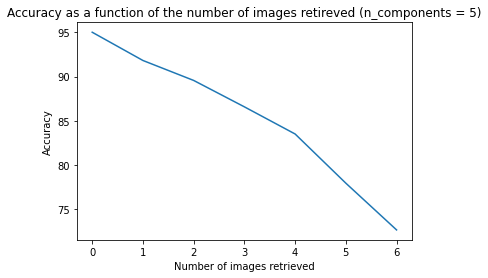

In [43]:
plt.plot(
    np.arange(len(sensitivity_results['variable_images_retrieved'].keys())),
    [value for value in list(sensitivity_results['variable_images_retrieved'].values())]
)
plt.title('Accuracy as a function of the number of images retireved (n_components = 5)')
plt.xlabel("Number of images retrieved")
plt.ylabel('Accuracy')
plt.show()
plt.close()

As expected the performance increases in the number of components. We see that the information contained in the first few components is very high and further components do not help the model. The number of images retrieved falls sharply. This also is obvious since the confidence falls and thus, if the model is forced to retrieve images, the perfomance must fall.